***Extractive step: BioBERT, K means***

pipeline:
I use BioBERT for embdeddings

I use Spacy for sentence segmentation 



In [ ]:
!pip install -q spacy
!python -m spacy download en_core_web_sm

In [1]:
import typing
from pprint import pprint
import os
import pickle

from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from sklearn.cluster import KMeans
from datasets import load_dataset
import pandas as pd

import spacy
# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")


# Check if MPS is available and set the device accordingly
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Metal Performance Shaders) device.")
    os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = "0.0"
    print(os.getenv('PYTORCH_MPS_HIGH_WATERMARK_RATIO'))
else:
    device = torch.device("cpu")
    print("MPS not available. Using CPU.")

# Load the dataset and cut down
dataset = load_dataset("allenai/mslr2022", "ms2", split='train')
# Use select to create a subset
# dataset = dataset.select(range(20,21))

# Initialize the BioBERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.1')
model = typing.cast(BertModel, BertModel.from_pretrained('dmis-lab/biobert-base-cased-v1.1').to(device))

Using MPS (Metal Performance Shaders) device.
0.0


/Users/michaelenghoekhor/Downloads/pytorch-test/env/lib/python3.8/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [2]:
def bert_sentence_embeddings(sentences: typing.List[str]):
    # Move inputs to the device
    inputs = tokenizer(sentences, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    # Move outputs back to CPU and compute mean
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
    # clear GPU memory
    del inputs, outputs
    torch.mps.empty_cache()
    return embeddings


def select_top_sentences(sentences, embeddings, n_sentences=5):
    # this is fixed : each selected sentence is from a different cluster
    if len(sentences) <= n_sentences:
        return ' '.join(sentences)

    kmeans = KMeans(n_clusters=n_sentences, n_init=10)
    kmeans.fit(embeddings)

    # Initialize a set to store indices of selected sentences
    selected_indices = set()
    top_sentences = []
    top_sentences_indices = []

    for i in range(n_sentences):
        # Calculate distances of all sentences from the i-th centroid
        distances = np.linalg.norm(embeddings - kmeans.cluster_centers_[i], axis=1)

        # Sort the sentences by their distance from the centroid
        sorted_indices = np.argsort(distances)

        # Find the closest sentence that hasn't been selected yet
        for index in sorted_indices:
            if index not in selected_indices:
                selected_indices.add(index)
                top_sentences.append(sentences[index])
                top_sentences_indices.append(index)
                break

    return ' '.join([sentences[i] + ("" if sentences[i].endswith(".") else ".") for i in sorted(top_sentences_indices)])


def process_row(row):
    review_id = row['review_id']
    abstract_list = row['abstract']

    # check if saved
    if os.path.exists(f'biobert_extractive_only_training_dataset/{review_id}.pkl'):
        with open(f'biobert_extractive_only_training_dataset/{review_id}.pkl', 'rb') as file:
            ret = pickle.load(file)

    else:
        combined_summary = ''

        all_sentences = []
        all_embeddings = []

        for abstract in abstract_list:
            # Check if the abstract is a string; if not, join it into a single string
            abstract_text = ' '.join(abstract) if isinstance(abstract, list) else abstract

            # Use SpaCy for sentence segmentation
            doc = nlp(abstract_text)
            sentences = [sent.text.strip() for sent in doc.sents]
            all_sentences.append(sentences)

            # Generate embeddings for each sentence
            embeddings = bert_sentence_embeddings(sentences)
            all_embeddings.extend(embeddings)
            # Select the top sentences from these embeddings
            summary = select_top_sentences(sentences, embeddings)

            # Combine the summaries from each abstract
            combined_summary += summary + (' ' if summary.endswith(".") else ". ")

        # intermediate save
        with open(f'biobert_extractive_only_training_dataset/{review_id}.pkl', 'wb') as file:
            ret = {
                "review_id": review_id,
                "summary": combined_summary.strip(),
                "sentences": all_sentences,  # save all to disk
                "embeddings": all_embeddings,
            }
            pickle.dump(ret, file)

    # get rid of sentences and embeddings
    del ret['sentences']
    del ret['embeddings']
    return ret


# Apply the function to each element of the dataset
summaries_dataset = dataset.map(process_row, num_proc=2)  # CHANGE THIS APPROPRIATELY

# Saving the dataset
with open('biobert_extractive_only_training_dataset.pkl', 'wb') as file:
    pickle.dump(summaries_dataset, file)


# Convert to pandas DataFrame
df = pd.DataFrame(summaries_dataset)
df = df[['review_id', 'summary']]

# Save to CSV
csv_file_path = 'biobert_extractive_only_training_dataset.csv'
df.to_csv(csv_file_path, index=True)

print(f"Saved summaries to {csv_file_path}")

Map:   0%|          | 0/14188 [00:00<?, ? examples/s]

In [7]:
# what's the disk size of dataset?
print(f"Size of dataset: {os.path.getsize(csv_file_path) / 1024 / 1024:.2f} MB")

Size of dataset: 1.50 MB


In [95]:
with open('biobert_extractive_only_training_dataset/15106233.pkl', 'rb') as file:
    investigate_pkl = pickle.load(file)

pprint(investigate_pkl['sentences'], width=200)

[['The influence of diurnal variations of mood ( DVM ) and sleep disturbances on treatment response was investigated in 42 patients with major depressive disorder ( not SAD ) under the treatment of '
  'either bright white light ( 2,500 lx ) or dim red light ( 50 lx ) .',
  'We found only a slight influence in certain subscales of DVM and no influence of sleep disturbances .',
  'These results are discussed under a clinical point of view and with respect to phase shift theories of depressive disorders'],
 ['In a group of 17 patients with non-SAD depressive disorders we compared the response of bipolar spectrum versus unipolar patients to treatment with light therapy .',
  'The main hypothesis was that bipolar spectrum depressed patients would preferentially respond to bright light therapy as compared to unipolar depressed patients .',
  'All patients were treated with either 400 or 2500 lux phototherapy for 2 h on seven consecutive days .',
  'All outcome measures , which included the 

In [76]:
pprint(summaries_dataset["summary"][0], width=200)

('METHODS We conducted a double-blind , r and omized clinical trial to investigate whether levosimendan reduces the severity of organ dysfunction in adults with sepsis . The primary outcome was the '
 'mean daily Sequential Organ Failure Assessment ( SOFA ) score in the intensive care unit up to day 28 ( scores for each of five systems range from 0 to 4 , with higher scores indicating more '
 'severe dysfunction ; maximum score , 20 ) . More patients in the levosimendan group than in the placebo group had supraventricular tachyarrhythmia ( 3.1 % vs. 0.4 % ; absolute difference , 2.7 '
 'percentage points ; 95 % CI , 0.1 to 5.3 ; P=0.04 ) . CONCLUSIONS The addition of levosimendan to st and ard treatment in adults with sepsis was not associated with less severe organ dysfunction '
 'or lower mortality . ( Funded by the NIHR Efficacy and Mechanism Evaluation Programme and others ; LeoPARDS Current Controlled Trials number , IS RCT N12776039 . ). Methods and Results — In this '
 'prospect

<Axes: >

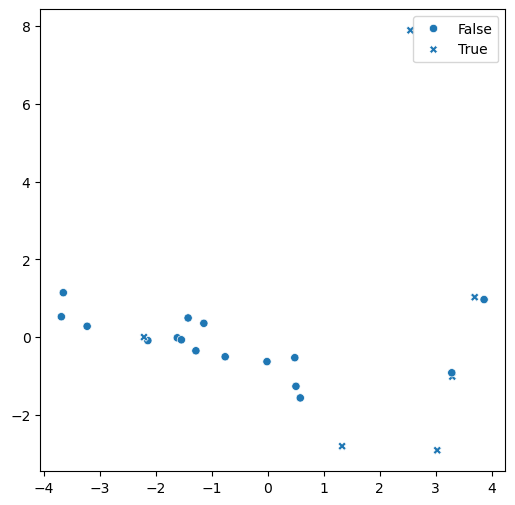

In [81]:
# view embeddings in reduced dimension, for the first abstract only
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)

#  filter by one abstract only
abstract_id = 9

# get relevant embeddings rows based on chosen abstract and its position in sentences
start_sentence_id = sum([len(sentences) for sentences in summaries_dataset['sentences'][0][:abstract_id]])
end_sentence_id = start_sentence_id + len(summaries_dataset['sentences'][0][abstract_id])

relevant_embeddings = summaries_dataset['embeddings'][0][start_sentence_id:end_sentence_id]
pca.fit(relevant_embeddings)
embeddings_2d = pca.transform(relevant_embeddings)

# was a sentence selected? check in `summary` (string)
selected = []
for i in range(len(summaries_dataset['sentences'][0][abstract_id])):
    selected.append(summaries_dataset['sentences'][0][abstract_id][i] in summaries_dataset['summary'][0])

# plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x=embeddings_2d[:,0], y=embeddings_2d[:,1], style=selected)


In [34]:
def bert_sentence_embeddings(sentences: typing.List[str]):
    embeddings = []
    for sentence in sentences:
        # Move inputs to the device
        inputs = tokenizer(sentence, return_tensors='pt', max_length=512, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        # Move outputs back to CPU
        embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy())
    return np.array(embeddings)

#this is fixed : each selected sentence is from a different cluster
def select_top_sentences(sentences, embeddings, n_sentences=5):
    if len(sentences) <= n_sentences:
        return ' '.join(sentences)

    kmeans = KMeans(n_clusters=n_sentences, n_init=10)
    kmeans.fit(embeddings)

    # Initialize a set to store indices of selected sentences
    selected_indices = set()
    top_sentences = []

    for i in range(n_sentences):
        # Calculate distances of all sentences from the i-th centroid
        distances = np.linalg.norm(embeddings - kmeans.cluster_centers_[i], axis=1)

        # Sort the sentences by their distance from the centroid
        sorted_indices = np.argsort(distances)

        # Find the closest sentence that hasn't been selected yet
        for index in sorted_indices:
            if index not in selected_indices:
                selected_indices.add(index)
                top_sentences.append(sentences[index])
                break

    return ' '.join(top_sentences)


def process_row(row):
    review_id = row['review_id']
    abstract_list = row['abstract']
    combined_summary = ''

    for abstract in abstract_list:
        # Check if the abstract is a string; if not, join it into a single string
        abstract_text = ' '.join(abstract) if isinstance(abstract, list) else abstract

        # Use SpaCy for sentence segmentation
        doc = nlp(abstract_text)
        sentences = [sent.text.strip() for sent in doc.sents]

        # Generate embeddings for each sentence
        embeddings = bert_sentence_embeddings(sentences)
        # Select the top sentences from these embeddings
        summary = select_top_sentences(sentences, embeddings)

        # Combine the summaries from each abstract
        combined_summary += summary + ' '

    return {"review_id": review_id, "summary": combined_summary.strip()}

# Apply the function to each element of the dataset
summaries_dataset_for_looped = dataset.map(process_row)

pprint(summaries_dataset_for_looped["summary"][0], width=200)

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

('The primary outcome was the mean daily Sequential Organ Failure Assessment ( SOFA ) score in the intensive care unit up to day 28 ( scores for each of five systems range from 0 to 4 , with higher '
 'scores indicating more severe dysfunction ; maximum score , 20 ) . CONCLUSIONS The addition of levosimendan to st and ard treatment in adults with sepsis was not associated with less severe organ '
 'dysfunction or lower mortality . More patients in the levosimendan group than in the placebo group had supraventricular tachyarrhythmia ( 3.1 % vs. 0.4 % ; absolute difference , 2.7 percentage '
 'points ; 95 % CI , 0.1 to 5.3 ; P=0.04 ) . ( Funded by the NIHR Efficacy and Mechanism Evaluation Programme and others ; LeoPARDS Current Controlled Trials number , IS RCT N12776039 . ) Patients '
 'were r and omly assigned to receive a blinded infusion of levosimendan ( at a dose of 0.05 to 0.2 μg per kilogram of body weight per minute ) for 24 hours or placebo in addition to st and ard care '
 '.

In [15]:
summaries_dataset_for_looped[0]

{'review_id': '29245998',
 'pmid': ['27705084',
  '18268152',
  '3219978',
  '4861009',
  '25315937',
  '15135713',
  '9164421',
  '21855289',
  '23740284',
  '27483065'],
 'title': ['Levosimendan for the Prevention of Acute Organ Dysfunction in Sepsis.',
  'Effects of Levosimendan on Left Ventricular Relaxation and Early Filling at Maintained Preload and Afterload Conditions After Aortic Valve Replacement for Aortic Stenosis',
  'Levosimendan for resuscitating the microcirculation in patients with septic shock: a randomized controlled study',
  'Levosimendan Versus Dobutamine in Myocardial Injury Patients with Septic Shock: A Randomized Controlled Trial',
  '[Effects of levosimendan on hemodynamics and cardiac function in patients with septic shock].',
  'Effects of levosimendan on circulating pro-inflammatory cytokines and soluble apoptosis mediators in patients with decompensated advanced heart failure.',
  'Myocardial efficiency during calcium sensitization with levosimendan: A non

***abstractive step: Long T5***

this is without batching

In [ ]:
# import gc
# from transformers import AutoTokenizer, LongT5ForConditionalGeneration
# import pandas as pd
# import torch
# from torch.cuda.amp import autocast
# from datasets import load_dataset


# # Set the device to MPS if available, else CPU
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# # Load LongT5 Model and Tokenizer
# model_to_use = "pszemraj/long-t5-tglobal-base-16384-book-summary"  # fine-tuned for summarization
# longt5_model = LongT5ForConditionalGeneration.from_pretrained(model_to_use).to(device)
# longt5_tokenizer = AutoTokenizer.from_pretrained(model_to_use)


# # Dictionary to store the final summaries
# final_summaries = {}

# # Iterate over each summary in the summaries dataset
# for row in summaries_dataset:
#     review_id = row['review_id']
#     extractive_summary = row['summary']

#     # Prepare the input for the model
#     inputs = longt5_tokenizer(
#         extractive_summary,
#         truncation=True,
#         padding="longest",
#         return_tensors="pt",
#         max_length=16384
#     ).to(device)

#     # Generate the summary with LongT5
#     try:
#         summary_ids = longt5_model.generate(
#             inputs['input_ids'],
#             num_beams=4,
#             min_length=50,
#             max_length=400,
#             length_penalty=2.0,
#             early_stopping=True
#         )

#         # Decode the generated IDs to text
#         longt5_summary = longt5_tokenizer.decode(
#             summary_ids[0],
#             skip_special_tokens=True
#         )

#         # Store the summary in the final summaries dictionary
#         final_summaries[review_id] = longt5_summary

#     except IndexError as e:
#         print(f"Error processing review_id {review_id}: {e}")
#         final_summaries[review_id] = ""

# # Display the final summaries
# for review_id, summary in final_summaries.items():
#     print(f"Review ID: {review_id}\nAbstractive Summary: {summary}\n")


In [ ]:
# import pickle

# # Saving the dataset
# # with open('summaries_dataset.pkl', 'wb') as file:
# #     pickle.dump(summaries_dataset, file)

# # Later, you can load the dataset
# with open('summaries_dataset.pkl', 'rb') as file:
#     summaries_dataset = pickle.load(file)


batching version 1

In [ ]:
# from transformers import AutoTokenizer, LongT5ForConditionalGeneration
# import pandas as pd
# import torch
# from torch.cuda.amp import autocast
# from datasets import load_dataset


# # Check if MPS is available and set the device accordingly
# if torch.backends.mps.is_available():
#     device = torch.device("mps")
#     print("Using MPS (Metal Performance Shaders) device.")
# else:
#     device = torch.device("cpu")
#     print("MPS not available. Using CPU.")

# # Load LongT5 Model and Tokenizer
# model_to_use = "pszemraj/long-t5-tglobal-base-16384-book-summary"  # fine-tuned for summarization
# longt5_model = LongT5ForConditionalGeneration.from_pretrained(model_to_use).to(device)
# longt5_tokenizer = AutoTokenizer.from_pretrained(model_to_use)

# # Define the batch size
# batch_size = 1

# # Initialize the results list
# results = []

# # Convert the dataset to a list of dictionaries if not already
# data_list = list(summaries_dataset)

# # Generate summaries in batches
# for i in range(0, len(data_list), batch_size):
#     batch = data_list[i:i + batch_size]
#     input_texts = [row['summary'] for row in batch]
#     review_ids_batch = [row['review_id'] for row in batch]

#     inputs = longt5_tokenizer(
#         input_texts,
#         truncation=True,
#         padding="longest",
#         return_tensors="pt",
#         max_length=16384
#     ).to(device)

#     try:
#         summary_ids = longt5_model.generate(
#             inputs['input_ids'],
#             num_beams=2,
#             no_repeat_ngram_size=2,
#             min_length=10,
#             max_length=512,
#             early_stopping=True
#         ).to('cpu')

#         batch_summaries = longt5_tokenizer.batch_decode(summary_ids, skip_special_tokens=True)

#         # Append each summary with its ReviewID to the results list
#         for review_id, summary in zip(review_ids_batch, batch_summaries):
#             results.append({'review_id': review_id, 'Summary': summary})

#     except Exception as e:
#         print(f"Error in batch starting at index {i}: {e}")
#         for review_id in review_ids_batch:
#             results.append({'review_id': review_id, 'Summary': ""})

# # Convert the results to a DataFrame
# summaries_df_val = pd.DataFrame(results)

# # Save the DataFrame to a CSV file
# output_file_val = 'summary_BioBERT_K_Means_Long_T5_prediction.csv'
# summaries_df_val.to_csv(output_file_val, index=True)
# print(f"Saved summaries to {output_file_val}")

#batching version 2: using a method that saves summaries and clears memory

In [ ]:
# from transformers import AutoTokenizer, LongT5ForConditionalGeneration
# import pandas as pd
# import torch
# import os
# import gc  # For garbage collection
# import pickle


# # Check for device availability and set accordingly
# if torch.cuda.is_available():
#     device = torch.device("cuda")
#     print("Using CUDA device.")
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
#     print("Using MPS (Metal Performance Shaders) device.")
# else:
#     device = torch.device("cpu")
#     print("CUDA and MPS not available. Using CPU.")


# # Load LongT5 Model and Tokenizer
# model_to_use = "pszemraj/long-t5-tglobal-base-16384-book-summary"  # fine-tuned for summarization
# longt5_model = LongT5ForConditionalGeneration.from_pretrained(model_to_use).to(device)
# longt5_tokenizer = AutoTokenizer.from_pretrained(model_to_use)

# # Define the batch size and save directory
# batch_size = 1
# save_dir = 'summaries'  # Directory to save individual summary files
# os.makedirs(save_dir, exist_ok=True)

# # Initialize the results list
# results = []



# #loading the .pkl file if needed
# # you can load the dataset
# with open('summaries_dataset.pkl', 'rb') as file:
#     summaries_dataset = pickle.load(file)



# # Convert the dataset to a list of dictionaries if not already
# data_list = list(summaries_dataset)

# #Select a subset of the dataset if needed
# data_list = data_list[1000:1020]


# # Generate summaries in batches
# for i in range(0, len(data_list), batch_size):
#     batch = data_list[i:i + batch_size]
#     input_texts = [row['summary'] for row in batch]
#     review_ids_batch = [row['review_id'] for row in batch]

#     inputs = longt5_tokenizer(
#         input_texts,
#         truncation=True,
#         padding="longest",
#         return_tensors="pt",
#         max_length=16384
#     ).to(device)

#     try:
#         summary_ids = longt5_model.generate(
#             inputs['input_ids'],
#             num_beams=2,
#             no_repeat_ngram_size=2,
#             min_length=10,
#             max_length=512,
#             early_stopping=True
#         ).to('cpu')

#         batch_summaries = longt5_tokenizer.batch_decode(summary_ids, skip_special_tokens=True)

#         # Save summaries and append to results
#         for review_id, summary in zip(review_ids_batch, batch_summaries):
#             with open(os.path.join(save_dir, f"{review_id}.txt"), "w") as f:
#                 f.write(summary)
#             results.append({'review_id': review_id, 'Summary': summary})

#     except Exception as e:
#         print(f"Error in batch starting at index {i}: {e}")
#         for review_id in review_ids_batch:
#             results.append({'review_id': review_id, 'Summary': ""})

#     # Clear memory
#     del inputs, summary_ids
#     if torch.cuda.is_available():
#         torch.cuda.empty_cache()
#     elif torch.backends.mps.is_available():
#         torch.mps.empty_cache()
#     gc.collect()

# # Convert the results to a DataFrame
# summaries_df_val = pd.DataFrame(results)

# # Define the destination folder
# output_folder = 'summaries'

# # Define the CSV file name within the folder
# output_file_val = os.path.join(output_folder, 'summary_BioBERT_K_Means_Long_T5_prediction.csv')
# # Save the DataFrame to the CSV file
# summaries_df_val.to_csv(output_file_val, index=True)
# print(f"Saved summaries to {output_file_val}")


#version 3: instead of saving to a txt file, append to a csv file 

In [ ]:
from transformers import AutoTokenizer, LongT5ForConditionalGeneration
import pandas as pd
import torch
import os
import gc  # For garbage collection
import pickle

# Check for device availability and set accordingly
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device.")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Metal Performance Shaders) device.")
else:
    device = torch.device("cpu")
    print("CUDA and MPS not available. Using CPU.")

# Load LongT5 Model and Tokenizer
model_to_use = "pszemraj/long-t5-tglobal-base-16384-book-summary"  # Fine-tuned for summarization
longt5_model = LongT5ForConditionalGeneration.from_pretrained(model_to_use).to(device)
longt5_tokenizer = AutoTokenizer.from_pretrained(model_to_use)

# Load the dataset from a pickle file
with open('summaries_dataset.pkl', 'rb') as file:
    summaries_dataset = pickle.load(file)

# Convert the dataset to a list
data_list = list(summaries_dataset)

# # Select a subset of the dataset for processing
# data_list = data_list[1240:1255]

# Define the destination folder and CSV file name
output_folder = 'summaries'
os.makedirs(output_folder, exist_ok=True)
output_file_val = os.path.join(output_folder, 'summary_BioBERT_K_Means_Long_T5_prediction.csv')

# Check if the output file already exists, create it with headers if not
if not os.path.exists(output_file_val):
    pd.DataFrame(columns=['review_id', 'Summary']).to_csv(output_file_val, index=False)

# Define the batch size
batch_size = 1

# Define the starting index
start_index = 1279

# Generate summaries in batches
for i in range(start_index, len(data_list), batch_size):
    batch = data_list[i:i + batch_size]
    input_texts = [row['summary'] for row in batch]
    review_ids_batch = [row['review_id'] for row in batch]

    # Tokenize the input texts
    inputs = longt5_tokenizer(
        input_texts,
        truncation=True,
        padding="longest",
        return_tensors="pt",
        max_length=16384
    ).to(device)

    try:
        # Generate summaries
        summary_ids = longt5_model.generate(
            inputs['input_ids'],
            num_beams=2,
            no_repeat_ngram_size=2,
            min_length=10,
            max_length=512,
            early_stopping=True
        ).to('cpu')

        # Decode the summaries
        batch_summaries = longt5_tokenizer.batch_decode(summary_ids, skip_special_tokens=True)

        # Append summaries directly to the CSV file
        with open(output_file_val, 'a') as f:
            pd.DataFrame({'review_id': review_ids_batch, 'Summary': batch_summaries}).to_csv(f, header=False, index=False)

    except Exception as e:
        print(f"Error in batch starting at index {i}: {e}")

    print(f"Index {i} done!")

    # Clear memory
    if 'inputs' in locals():
        del inputs
    if 'summary_ids' in locals():
        del summary_ids
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    elif torch.backends.mps.is_available():
        torch.mps.empty_cache()
    gc.collect()

print(f"Saved summaries to {output_file_val}. Abstractive summarization portion done!")

#batching using huggingface module, map

In [ ]:
# import pandas as pd
# import torch
# from transformers import AutoTokenizer, LongT5ForConditionalGeneration
# from datasets import load_dataset

# # Check if MPS is available and set the device accordingly
# if torch.backends.mps.is_available():
#     device = torch.device("mps")
#     print("Using MPS (Metal Performance Shaders) device.")
# else:
#     device = torch.device("cpu")
#     print("MPS not available. Using CPU.")

# # Load LongT5 Model and Tokenizer
# model_to_use = "pszemraj/long-t5-tglobal-base-16384-book-summary"  # fine-tuned for summarization
# longt5_model = LongT5ForConditionalGeneration.from_pretrained(model_to_use).to(device)
# longt5_tokenizer = AutoTokenizer.from_pretrained(model_to_use)

# # Load your dataset here (assuming 'summaries_dataset' is your dataset name)
# # summaries_dataset = load_dataset('your_dataset_name')

# # Define the batch processing function
# def process_batch(batch):
#     input_texts = batch['summary']
#     review_ids_batch = batch['review_id']

#     inputs = longt5_tokenizer(
#         input_texts,
#         truncation=True,
#         padding="longest",
#         return_tensors="pt",
#         max_length=16384
#     ).to(device)

#     try:
#         summary_ids = longt5_model.generate(
#             inputs['input_ids'],
#             num_beams=4,
#             min_length=50,
#             max_length=512,
#             early_stopping=True
#         ).to('cpu')

#         batch_summaries = longt5_tokenizer.batch_decode(summary_ids, skip_special_tokens=True)

#         # Return processed results
#         return {'review_id': review_ids_batch, 'Abstractive Summary': batch_summaries}

#     except Exception as e:
#         print(f"Error in processing batch: {e}")
#         # Returning empty summaries in case of error
#         return {'review_id': review_ids_batch, 'Abstractive Summary': ['' for _ in review_ids_batch]}

# # Apply the function to the entire dataset using map
# batch_size = 1  # Set your batch size
# processed_dataset = summaries_dataset.map(process_batch, batched=True, batch_size=batch_size)

# # Convert the processed results to a pandas DataFrame
# summaries_df = pd.DataFrame.from_dict({
#     'review_id': processed_dataset['review_id'],
#     'Abstractive Summary': processed_dataset['Abstractive Summary']
# })

# # Save the DataFrame to a CSV file
# output_file = 'summary_predictions.csv'
# summaries_df.to_csv(output_file, index=False)
# print(f"Saved summaries to {output_file}")
